<a href="https://colab.research.google.com/github/sachinthadilshann/pytorch_course_by_DanielBourke/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Importing PyTorch and setting up device-agnostic code

In [20]:
import torch
from torch import nn

torch.__version__

'2.9.0+cpu'

In [21]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')


Using device: cpu


## 1.0 Getting Data

In [22]:
import requests
import zipfile
from pathlib import Path

data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
    print(f'{image_path} directory exists.')
else:
    print(f'Did not find {image_path} directory, creating one...')
    image_path.mkdir(parents=True, exist_ok=True)

#Download
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print('Downloading pizza, steak, sushi data...')
    f.write(request.content)

#unzip

with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
  print("Unzipping pizza,steak and sushi data")
  zip_ref.extractall(image_path)







data/pizza_steak_sushi directory exists.
Unzipping pizza,steak and sushi data


In [23]:
import os

def walk_through_dirr(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} dieections and {len(filenames)} images in '{dirpath}'")

In [24]:
walk_through_dirr(image_path)

There are 2 dieections and 0 images in 'data/pizza_steak_sushi'
There are 3 dieections and 0 images in 'data/pizza_steak_sushi/train'
There are 0 dieections and 72 images in 'data/pizza_steak_sushi/train/sushi'
There are 0 dieections and 78 images in 'data/pizza_steak_sushi/train/pizza'
There are 0 dieections and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 3 dieections and 0 images in 'data/pizza_steak_sushi/test'
There are 0 dieections and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 0 dieections and 25 images in 'data/pizza_steak_sushi/test/pizza'
There are 0 dieections and 19 images in 'data/pizza_steak_sushi/test/steak'


In [25]:
#setup train and test paths

train_dir = image_path / 'train'
test_dir = image_path / 'test'



###2.1 Visualize an image

data/pizza_steak_sushi/train/pizza/618348.jpg
pizza
Random image path: data/pizza_steak_sushi/train/pizza/618348.jpg
Image class: pizza
Image height: 512
Image width: 512


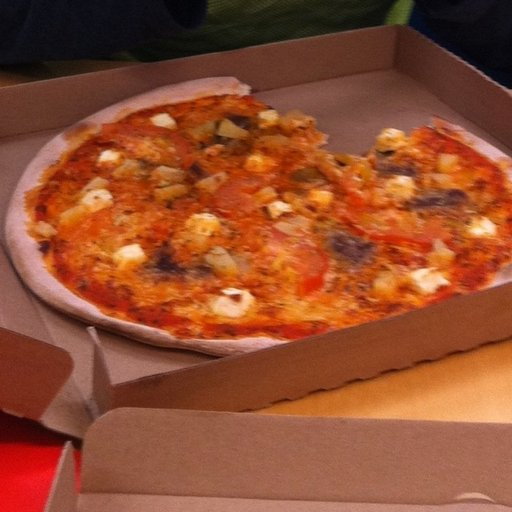

In [26]:
import random
from PIL import Image

image_path_list  = list(image_path.glob("*/*/*.jpg"))


random_image_path = random.choice(image_path_list)
print(random_image_path)


image_class = random_image_path.parent.stem
print(image_class)

img = Image.open(random_image_path)
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

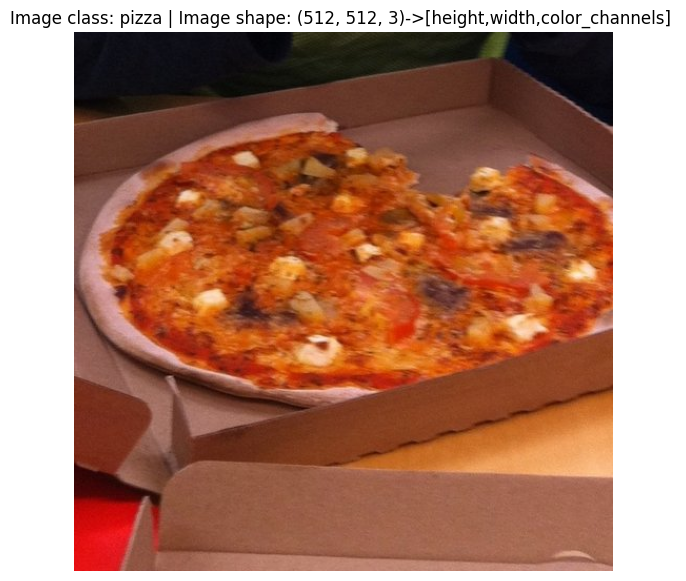

In [27]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}->[height,width,color_channels] ")
plt.axis(False)


##3. Transforming Data

###3.1 Transforming data with torchvision.transforms

In [28]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [47]:

data_transform = transforms.Compose([transforms.Resize(size=(64,64)),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.ToTensor()])

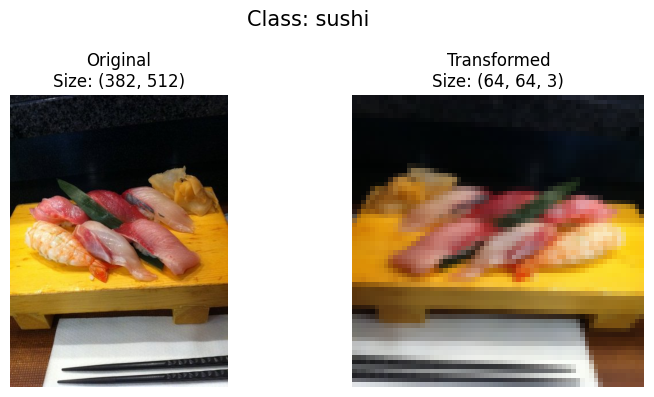

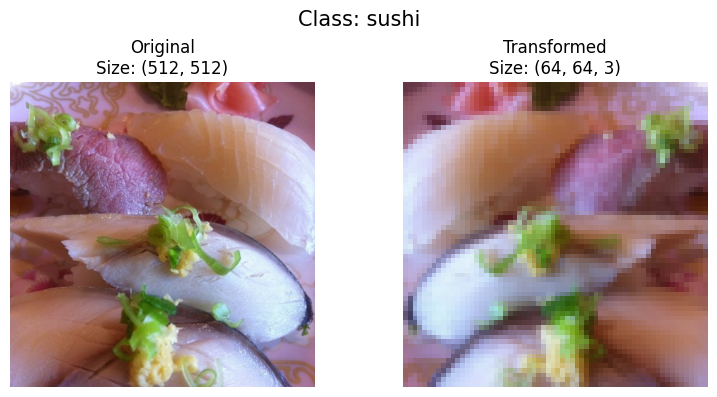

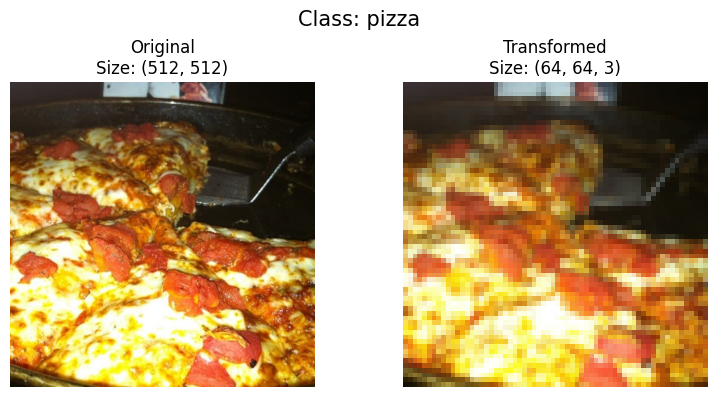

In [49]:
import random
import matplotlib.pyplot as plt
from PIL import Image

def plot_transform_images(image_path, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_path, k=n)

    for img_path in random_image_paths:
        with Image.open(img_path) as f:
            fig, ax = plt.subplots(1, 2, figsize=(8, 4))

            # Original
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis("off")

            # Transformed
            transformed_image = transform(f)
            transformed_image = (
                transformed_image.permute(1, 2, 0)
                .clamp(0, 1)
                .numpy()
            )

            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {img_path.parent.stem}", fontsize=15)
            plt.tight_layout()
            plt.show()

plot_transform_images(image_path_list,
                      data_transform,
                      n=3,
                      seed=42)
